# Exercise 1 - Robot Control with Optimization in the Simulation

In this exercise, we generate a sequence of control signals to drive the robot towards a target defined in the task space. 

Instead of directly solving the **inverse kinematics** problem, we consider to formulate the problem as an optimization problem and solve the optimization problem with functions provided in the popular python package **scipy**. 

With the optimization formulation, we can also add more costs that lead to different behaviour of the robot during approaching the desired target. We provide 6 different objective functions in this exercise.

In order to run this exercise, please install the python packages: numpy, matplotlib, scipy and pybullet with
`pip install numpy matplotlib scipy pybullet`

In [1]:
import time  # For sleep
import numpy as np  # For numerical processing
import matplotlib.pyplot as plt  # Plotting
import pybullet as pb  # Physics simulation

from scipy.optimize import minimize, Bounds  # Numerical optimization

In [2]:
# These are from us:
import controllers  # Controller driving the robot
import kuka  # The robot

from kukaEnv import KukaGripperEnv  # Our simulation environment

## Objective Functions

In order to get the target joint velocity, we need formulate an optimization problem. 

The most important component of an optimization problem is its **objective function**.

In [15]:
# 1. Find dq such that || dx - Jdq || is minimized
def f1(dq, jac_trans, desired_velocity):
    return np.linalg.norm(desired_velocity - np.dot(jac_trans, dq))

def f1_derivative(dq, jac_trans, desired_velocity):
    return -2 * np.dot(jac_trans.T, desired_velocity - np.dot(jac_trans, dq))


# 2. Find dq such that || dx - Jdq || is minimized and such that the motion of the 5th joint is penalized
def f2(dq, jac_trans, desired_velocity):
    return np.linalg.norm(desired_velocity - np.dot(jac_trans, dq)) + dq[4]**2


# 3. Find dq such that || dx - Jdq || is minimized and such that high velocities are penalized
def f3(dq, jac_trans, desired_velocity):
    weights = 2e-4 * np.diag([1., 1., 1., 1., 1., 1., 1.])
    return np.linalg.norm(desired_velocity - np.dot(jac_trans, dq)) + np.dot(dq.T, np.dot(weights, dq))


# 4. Find dq such that || dx - Jdq || is minimized and such that the motion of the 3 first joints is penalized
# 3x more than the motion of the 4 last joints
def f4(dq, jac_trans, desired_velocity):
    weights = 1e-3 * np.diag([1., 1., 1., 0., 0., 0., 0.])
    return np.linalg.norm(desired_velocity - np.dot(jac_trans, dq)) + np.dot(dq.T, np.dot(weights, dq))


# 2. Find dq such that || dx - Jdq || is minimized along x and y
def f5(dq, jac_trans, desired_velocity):
    error = desired_velocity - np.dot(jac_trans, dq)
    weights = 2 * np.eye(3)
    weights[2, 2] = 0.0
    return np.sqrt(np.dot(error.T, np.dot(weights, error)))


# 6. Find dq such that || dx - Jdq || is minimized and such that the orientation change is penalized
def f6(dq, jac_trans, desired_velocity, jac_rot):
    return np.linalg.norm(desired_velocity - np.dot(jac_trans, dq)) + np.linalg.norm(np.dot(jac_rot, dq))**2

## Setup the environment
1. Create the environment
2. Create a joint position controller
    - A joint position controller takes the target joint positions as input and sends the joint velocities to the robot.
3. Set the target position of the TCP x_d
4. Set the number of interations

In [4]:
# Create environment
env = KukaGripperEnv(block_pos=[.65, 0.12, -0.15, np.pi/2])
# Create joint position controller
ctrl = controllers.SimpleJointPController(kp=.01)
# Set target position x_d
target_position = [.65, 0.1, 0.1, 0]
# Set number of interations
nb_iters = 250

###### Note: Although the Kuka robot has 7 joints, the last (7th) joint rotates the gripper and cannot determine the position of the TCP.

## Function to run the robot

At each timestep, we solve an optimization problem with one of the objective functions defined above.

In [21]:
def control_robot_with_optimization():
    env.reset_env(block_pos=[.65, 0.12, -0.15, np.pi/2])
    
    # Stop and wait for "space" key to start
    print("Press space in the simulation window to start ...")
    while not env.started():
        env.move_camera()
        time.sleep(env._timeStep)
        
    log_joint_angles = np.zeros((nb_iters, 7))
    log_joint_velocities = np.zeros((nb_iters, 7))
    log_position = np.zeros((nb_iters, 3))
    log_function = np.zeros(nb_iters)

    for i in range(nb_iters):
        if i % 10 == 0:
            print("{} ".format(i), end="", flush=True)
        
        # Get current state
        joint_angles = env.get_state(to_ctrl=kuka.JOINT)
        position = env.get_state(to_ctrl=kuka.TCP)  # End-effector position

        # Desired velocity in function of the target position
        desired_velocity = 5e+3 * np.array(target_position - position)[:3]

        # Current position and rotation jacobian of the robot
        jac_trans, jac_rot = env.compute_jacobian()
        jac_trans = np.array(jac_trans)
        jac_rot = np.array(jac_rot)

        # Initial Variable
        dq0 = np.zeros(7)

        # Optimize function with scipy minimize
        # 1. Optimize the function using the Newton conjugate gradient method.
        # Note: the derivative of the function must be provided.
        res = minimize(f1, dq0, args=(jac_trans, desired_velocity), method='Newton-CG', jac=f1_derivative, options={'disp': False})
        
        # 2. Optimize the function using the BFGS method. The derivative of the function does not need to be provided.
        # res = minimize(f1, dq0, args=(jac_trans, desired_velocity), method='BFGS', options={'disp': False})
        
        # Note: f6 requires 3 positional arguments.
        # res = minimize(f6, dq0, args=(jac_trans, desired_velocity, jac_rot), method='BFGS', options={'disp': False})
       
        # 3. Optimize the function with additional bounds on the joint velocities.
        # Note: not all the optimization method support bound constraints, so that you should choose an adapted one.
        # bounds = Bounds(-500 * np.ones(7), 500 * np.ones(7))
        # res = minimize(f1, dq0, args=(jac_trans, desired_velocity), method='SLSQP', bounds=bounds, options={'disp': False})

        # Results: joint velocities
        joint_velocities = res.x
        # Print result and function value
        # print('The minimum value of the function {} is achieved for dq {}'.format(res.fun, res.x))

        # Define desired joint position by integrating the desired joint velocity
        target_state = joint_angles + joint_velocities * env._timeStep

        # Set controller, run one simulation step
        ctrl.set_target(target_state)
        env.run_controller_1step(ctrl)

        # Logs
        log_joint_angles[i] = joint_angles
        log_joint_velocities[i] = joint_velocities
        log_position[i] = position[:3]
        log_function[i] = res.fun
    
    env.close_gripper()
    
    print("Done.")
    
    return log_joint_angles, log_joint_velocities, log_position, log_function

## Run the function

In [8]:
log_jang_f1, log_jvel_f1, log_tpos_f1, log_func_f1 = control_robot_with_optimization()

Press space in the simulation window to start ...
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 Done.


### Change the code of the function and try *f2*
###### Note: Don't forget to re-run the function cell after changing the function

In [10]:
log_jang_f2, log_jvel_f2, log_tpos_f2, log_func_f2 = control_robot_with_optimization()

Press space in the simulation window to start ...
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 Done.


## Plot the results

###### compare the result given by the objective function *f1* and the objective function *f2*

Plot the 5-th joint positions and velocity.

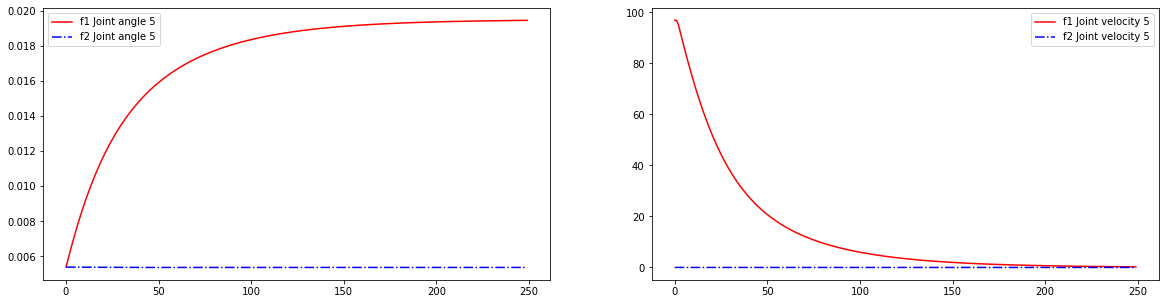

In [11]:
fig1 = plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(log_jang_f1[:, 4], 'r-', label='f1 Joint angle 5')
plt.plot(log_jang_f2[:, 4], 'b-.', label='f2 Joint angle 5')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(log_jvel_f1[:, 4], 'r-', label='f1 Joint velocity 5')
plt.plot(log_jvel_f2[:, 4], 'b-.', label='f2 Joint velocity 5')
plt.legend()

### Change the code of the function and try *f3*
###### Note: Don't forget to re-run the function cell after changing the function

In [13]:
log_jang_f3, log_jvel_f3, log_tpos_f3, log_func_f3 = control_robot_with_optimization()

Press space in the simulation window to start ...
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 Done.


###### compare the result given by the objective function *f1* and the objective function *f3*

Plot the joint velocity for all 6 joints (7-th joint does not affect the objective function).

The movement of all joints are penalized, the robot cannot reach the target very well.

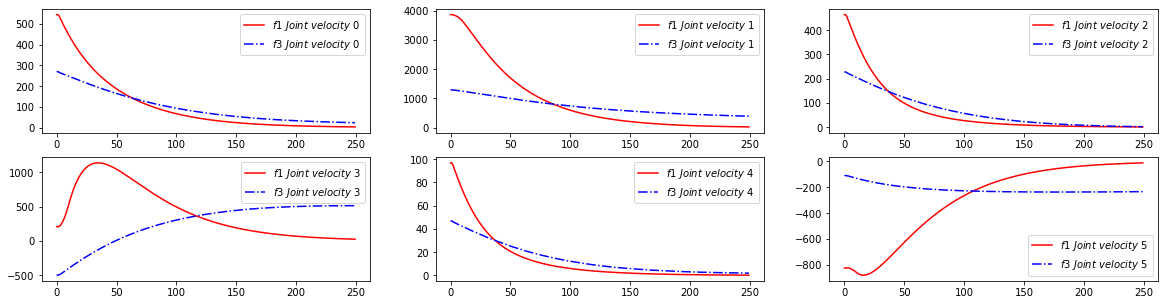

In [14]:
fig = plt.figure(figsize=(20, 5))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(log_jvel_f1[:,i], 'r-', label=r'$f1\ Joint\ velocity\ {}$'.format(i))
    plt.plot(log_jvel_f3[:,i], 'b-.', label=r'$f3\ Joint\ velocity\ {}$'.format(i))
    plt.legend()

### Change the code of the function and try *f4*
###### Note: Don't forget to re-run the function cell after changing the function

In [16]:
log_jang_f4, log_jvel_f4, log_tpos_f4, log_func_f4 = control_robot_with_optimization()

Press space in the simulation window to start ...
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 Done.


###### compare the result given by the objective function *f1* and the objective function *f4*

Plot the joint velocity for all 6 joints (7-th joint does not affect the objective function).

The movement of the first three joints are penalized. The robot tries to use other joints to compensate the velocity error.

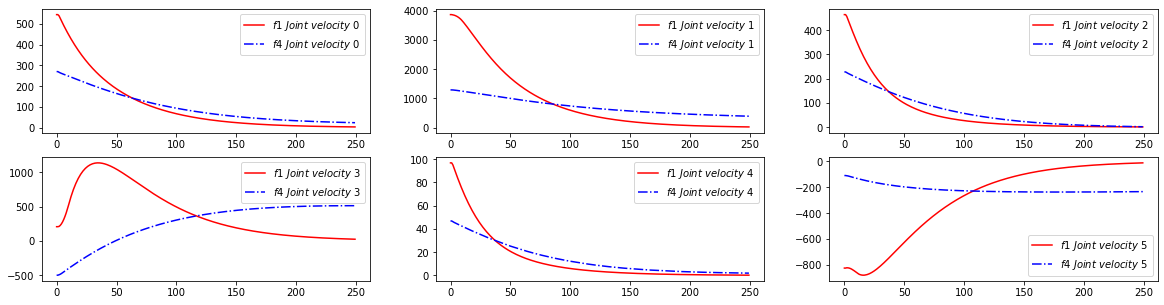

In [17]:
fig = plt.figure(figsize=(20,5))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(log_jvel_f1[:, i], 'r-', label=r'$f1\ Joint\ velocity\ {}$'.format(i))
    plt.plot(log_jvel_f4[:, i], 'b-.', label=r'$f4\ Joint\ velocity\ {}$'.format(i))
    plt.legend()

### Change the code of the function and try *f5*
###### Note: Don't forget to re-run the function cell after changing the function

In [19]:
log_jang_f5, log_jvel_f5, log_tpos_f5, log_func_f5 = control_robot_with_optimization()

Press space in the simulation window to start ...
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 Done.


###### compare the result given by the objective function *f1* and the objective function *f5*

Plot the TCP positions. In x- and y-direction, with *f5*, the robot cannot reach the target any more.

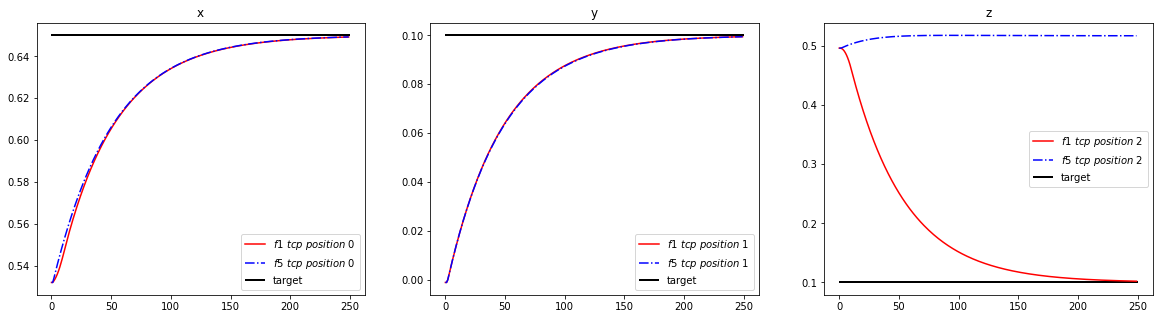

In [20]:
fig = plt.figure(figsize=(20, 5))

titles = ['x', 'y', 'z']
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(titles[i])
    plt.hlines(target_position[i], 0, nb_iters, color='k', linewidth=2., label='target')
    plt.plot(log_tpos_f1[:, i], 'r-', label=r'$f1\ tcp\ position\ {}$'.format(i))
    plt.plot(log_tpos_f5[:, i], 'b-.', label=r'$f5\ tcp\ position\ {}$'.format(i))
    plt.legend()

### Change the code of the function and try *f6*
###### Note: Don't forget to re-run the function cell after changing the function

In [22]:
log_jang_f6, log_jvel_f6, log_tpos_f6, log_func_f6 = control_robot_with_optimization()

Press space in the simulation window to start ...
0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 Done.


###### compare the result given by the objective function *f1* and the objective function *f6*

Plot the joint positions. With *f6*, the robot does not change the orientation.

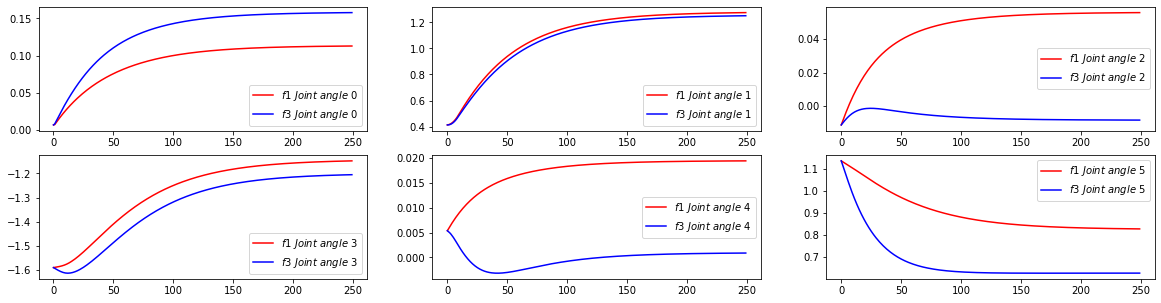

In [23]:
fig = plt.figure(figsize=(20,5))

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(log_jang_f1[:, i], 'r-', label=r'$f1\ Joint\ angle\ {}$'.format(i))
    plt.plot(log_jang_f6[:, i], 'b-', label=r'$f3\ Joint\ angle\ {}$'.format(i))
    plt.legend()

In [24]:
# disconnet physic server
pb.disconnect()